# Defining 1D and 2D Gaussian Mixture Classes

These include methods to find mean, median (in 1D case only), and mode(s).

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import bisect, fmin
from scipy.stats import norm


#Hides a warning from the output
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
class GaussianMixture1D:
  def __init__(self, scalars:list, means:list, variances:list):
    assert len(scalars) == len(means) == len(variances)
    assert sum(scalars) ==1
    self.data = tuple(zip(scalars,means,variances))

  def _G_Density(self, x, mu, vari):
    """
    Calculates the Gaussian density at a given x, for given mean, mu, and variance, vari.
    """
    return (1 / math.sqrt(2 * math.pi * vari)) * math.exp(-((x - mu)**2) / (2 * vari))

  def _CDFofMixture(self, x):
    """
    Calculates the cumulative distribution function of the Gaussian mixture at a given x.
    """
    mixture_cdf = 0
    for scalar, mean, variance in self.data:
      mixture_cdf += scalar * norm.cdf(x, loc=mean, scale=math.sqrt(variance))
    return mixture_cdf

  def __call__(self, x):
    """
    Calculates the density of Gaussian mixture at a given x.
    """
    mixture_density = 0
    for scalar, mean, variance in self.data:
      mixture_density += scalar * self._G_Density(x, mean, variance)
    return mixture_density

  def plot(self, plot_components=True):
    """
    Plots the Gaussian mixture.
    If plot_components = True, the individual summands will also be plotted (on a separate figure).
    This allows you to see how the different components contribute to the mixture.
    """
    min_val = min(mean - 4 * math.sqrt(variance) for scalar, mean, variance in self.data)
    max_val = max(mean + 4 * math.sqrt(variance) for scalar, mean, variance in self.data)

    x_vals = np.linspace(min_val, max_val, 1000)
    mixture_y = [self(pt) for pt in x_vals]

    if plot_components:
      fig, axes = plt.subplots(1, 2, figsize=(15, 6))

      # Plot individual components on left axis
      for scalar, mean, variance in self.data:
        component_y = [scalar * self._G_Density(val, mean, variance) for val in x_vals]
        axes[0].plot(x_vals, component_y, label=f'{scalar}N({mean},{variance})')
      axes[0].set_xlabel('value')
      axes[0].set_ylabel('density')
      axes[0].set_title('Plot of Individual Gaussian Summands (incl. scaling)')
      axes[0].legend()
      axes[0].grid(True)

      # Plot Gaussian mixture
      axes[1].plot(x_vals, mixture_y, linewidth=2, color='black')
      axes[1].set_xlabel('value')
      axes[1].set_ylabel('density')
      axes[1].set_title('Plot of Gaussian Mixture')
      axes[1].grid(True)
      plt.show()

    else:
      # Just plot Gaussian mixture
      plt.plot(x_vals, mixture_y, linewidth=2, color='black')
      plt.xlabel('value')
      plt.ylabel('density')
      plt.title('Plot of Gaussian Mixture')
      plt.grid(True)
      plt.show()

  def mean(self):
    """
    Calculates the mean of the Gaussian mixture.
    """
    return sum(scalar * mean for scalar, mean, _ in self.data)

  def modes(self):
    """
    Finds the modes (local maxima) of the Gaussian mixture using numerical methods.
    There may be duplicates in returned list (if mixture of N Gaussians has <N modes).
    I am working under the assumption that starting at the mean of each component will lead to all modes.
    ^This seems reasonable, but I am not 100% sure. It's definitely valid for this exercise.
    You can at least visually confirm all modes have been found by using `modes` method alongside `plot` method.
    """
    modes = []
    for scalar, mean, variance in self.data:
      # We want to find local maxima, so we find local minima of the negative of the density function
      # This is because scipy optimisation methods are focused on finding minima.
      result = fmin(lambda x: -self(x), mean,disp=False)
      modes.append(float(result))
    return modes

  def median(self):
    """
    Calculates the median of the Gaussian mixture using the bisection method.
    """
    MedIsRootOfThisFunc = lambda x: self._CDFofMixture(x) - 0.5

    # The median must lie between (or on) the smallest mean and largest mean.
    min_val = min(mean for _, mean, _ in self.data)
    max_val = max(mean for _, mean, _ in self.data)

    # Use scipy.bisect to find the median (aka root of the lambda function)
    return bisect(MedIsRootOfThisFunc, min_val, max_val)

In [3]:
class GaussianMixture2D:
  def __init__(self, scalars:list, means:list, covariances:list):
    assert len(scalars) == len(means) == len(covariances)
    assert sum(scalars) ==1
    self.data = tuple(zip(np.array(scalars),np.array(means),np.array(covariances)))

  def _G_Density_2D(self, x1, x2, mu:list, covari):
    """
    Calculates the 2D Gaussian density at a given x=(x1,x2), for given mean =(mu1,mu2)
    and covariance matrix [[cov11, cov12], [cov21, cov22]].
    Uses Equation (6.63) from MML book.
    """
    x = np.array([x1, x2])
    normalisation = 1 / (2 * np.pi * np.sqrt(np.linalg.det(covari)))
    exp_part = np.exp(-0.5*((x-mu).T @ np.linalg.inv(covari) @ (x-mu)))
    return normalisation * exp_part

  def __call__(self, x):
    """
    Calculates the density of Gaussian mixture at a given point x = (x1,x2).
    """
    mixture_density = 0
    for scalar, mean, covariance in self.data:
      mixture_density += scalar * self._G_Density_2D(x[0], x[1], mean, covariance)
    return mixture_density

  def plot(self):
    """
    Plots the Gaussian mixture.
    """
    x_range_min = min(mean[0] - 4 * math.sqrt(covariance[0][0]) for _, mean, covariance in self.data)
    x_range_max = max(mean[0] + 4 * math.sqrt(covariance[0][0]) for _, mean, covariance in self.data)
    y_range_min = min(mean[1] - 4 * math.sqrt(covariance[1][1]) for _, mean, covariance in self.data)
    y_range_max = max(mean[1] + 4 * math.sqrt(covariance[1][1]) for _, mean, covariance in self.data)
    x_vals = np.linspace(x_range_min, x_range_max, 100)
    y_vals = np.linspace(y_range_min, y_range_max, 100)

    X, Y = np.meshgrid(x_vals, y_vals)
    mixture_z = np.array([[self([x, y]) for x in x_vals] for y in y_vals])

    fig = plt.figure(figsize=(9,16))
    #projection plot
    ax = fig.add_subplot(211, projection='3d')
    ax.plot_surface(X, Y, mixture_z, cmap='gnuplot')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('density')
    ax.set_title('Plot of 2D Gaussian Mixture')
    # Contour plot
    ax2 = fig.add_subplot(212)
    contour = ax2.contourf(X, Y, mixture_z, levels=16, cmap='gnuplot')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title('Contour Plot of 2D Gaussian Mixture')
    fig.colorbar(contour, ax=ax2, label='density')

    plt.tight_layout()
    plt.show()


  def mean(self):
    """
    Calculates the mean of the 2D Gaussian mixture.
    """
    return sum(scalar * mean for scalar, mean, _ in self.data)

  def modes(self):
    """
    Finds the modes (local maxima) of the 2D Gaussian mixture using numerical methods.
    There may be duplicates in returned list (if mixture of N Gaussians has <N modes).
    # We work under the assumption that starting at the mean of each component will lead to all modes.
    # ^This seems reasonable, but I am not 100% sure. It's definitely valid for this exercise.
    """
    modes = []
    for _, mean, _ in self.data:
      # We want to find local maxima, so we find local minima of the negative of the density function
      # This is because scipy optimisation methods are focused on finding minima.
      result = fmin(lambda x: -self(x), mean, disp=False)
      modes.append(result)
    return modes

# Question 6.2b.

The marginal distribution for $x$ is

$$p(x) = 0.4\mathcal{N}(10,1) +0.6\mathcal{N}(0,8.4).$$

The marginal distribution for $y$ is

$$p(y) = 0.4\mathcal{N}(2,1) +0.6\mathcal{N}(0,1.7).$$


The mean, modes, medians for each are given below (numerically calculated).

Plots showing the summands of each mixture (with scaling), as well as a plot of the mixture itself, are also given.

Marginal distribution of X

Mean of X: 4.0
Modes of X: [9.9984130859375, 0.0]
Median of X: 2.803854077350252


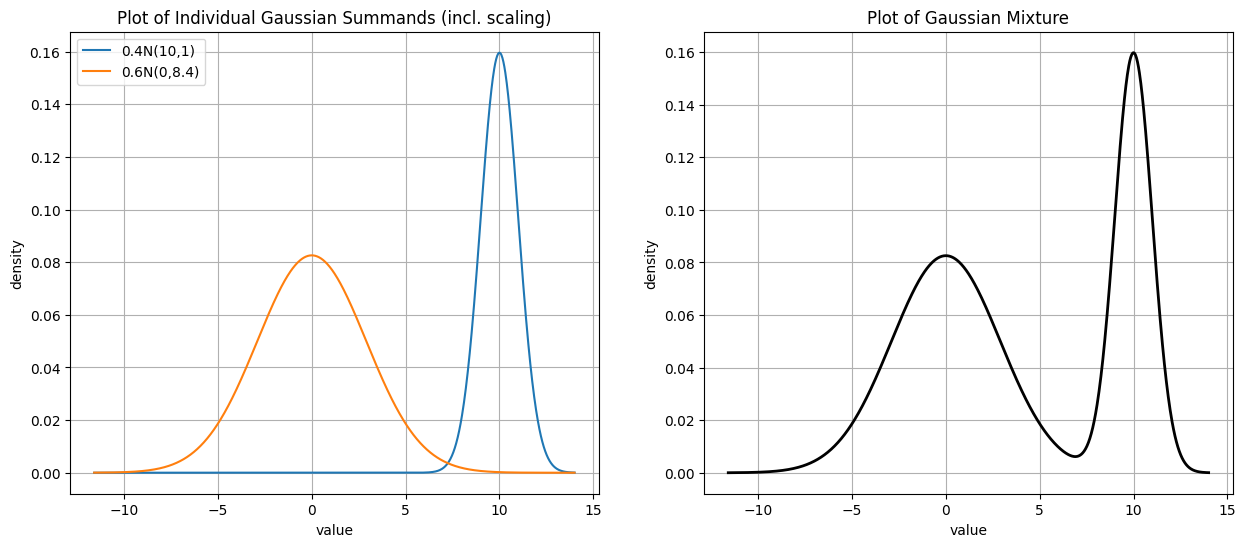

Marginal distribution of Y

Mean of Y: 0.8
Modes of Y: [1.3307617187499994, 1.3308125000000013]
Median of Y: 0.868644777487134


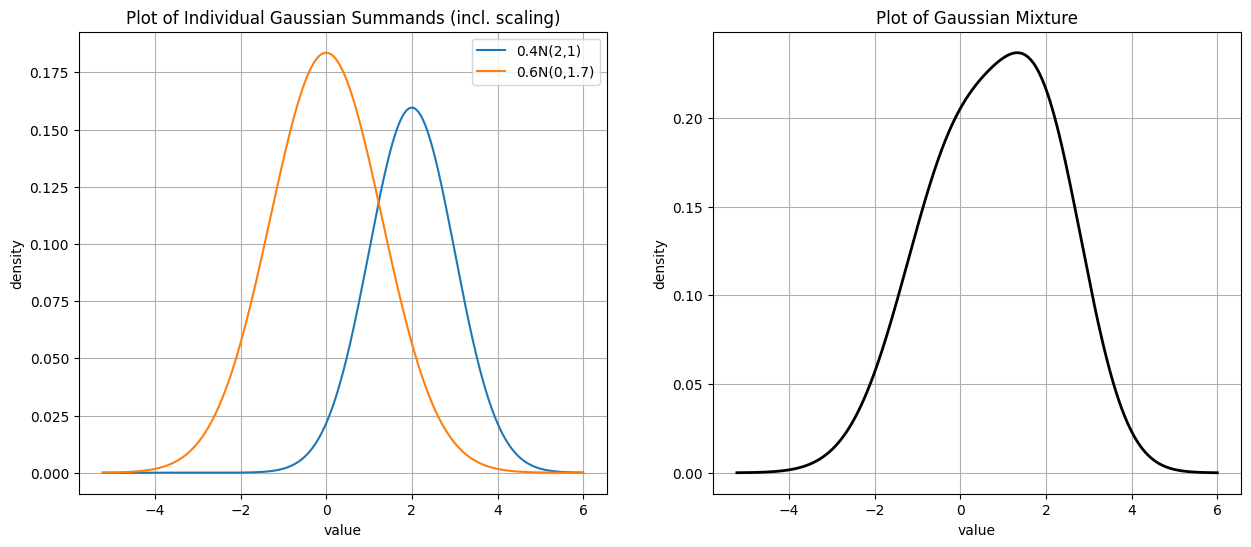

In [4]:
print("Marginal distribution of X\n")

marginalX = GaussianMixture1D([0.4, 0.6], [10, 0], [1, 8.4])
print("Mean of X:", marginalX.mean())
print("Modes of X:", marginalX.modes())
print("Median of X:", marginalX.median())
marginalX.plot()

print("Marginal distribution of Y\n")

marginalY = GaussianMixture1D([0.4, 0.6], [2, 0], [1, 1.7])
print("Mean of Y:", marginalY.mean())
print("Modes of Y:", marginalY.modes())
print("Median of Y:", marginalY.median())
marginalY.plot()

# Question 6.2c.

The 2D Gaussian mixture is
$$p\left(\begin{bmatrix} x \\ y \end{bmatrix}\right) = 0.4\mathcal{N}\left(\begin{bmatrix} 10 \\ 2 \end{bmatrix}, \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \right) + 0.6\mathcal{N}\left(\begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 8.4 & 2 \\ 2 & 1.7 \end{bmatrix} \right)$$

Mean of 2D mixture: [4.  0.8]
Modes of 2D mixture: [array([9.99854183, 2.00037986]), array([0., 0.])]


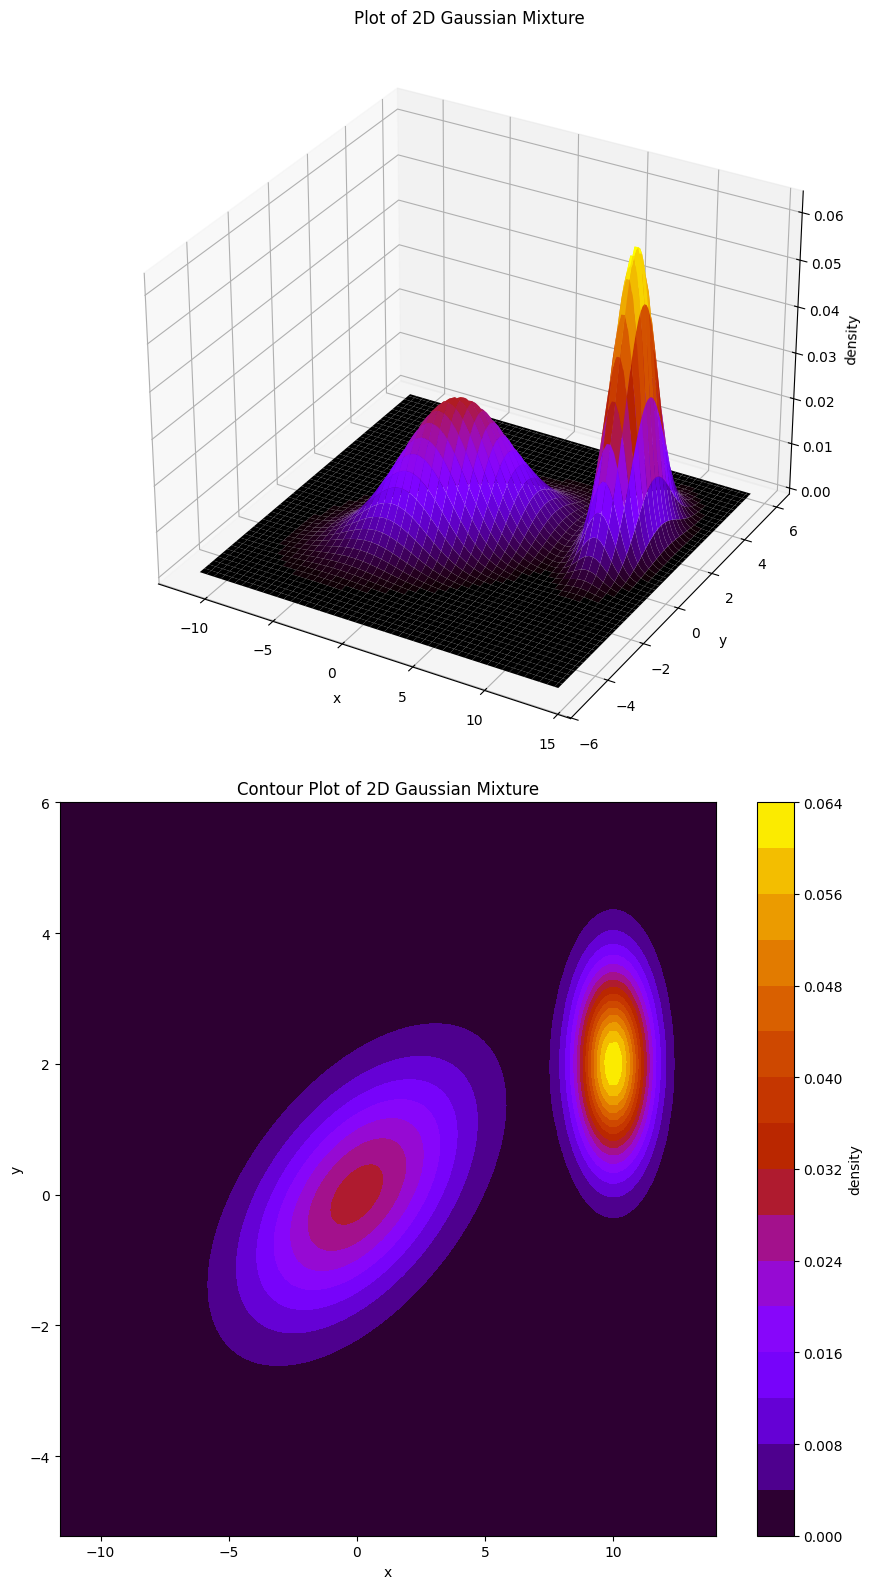

In [5]:
mixture = GaussianMixture2D([0.4, 0.6], [[10, 2], [0, 0]], [[[1, 0], [0, 1]], [[8.4, 2], [2, 1.7]]])
print("Mean of 2D mixture:", mixture.mean())
print("Modes of 2D mixture:", mixture.modes())
mixture.plot()